# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **IBRD Credit Scorecard Predictive Engine** |

# II. Notebook Target Definition

_Insert Text Here_

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score # Will be updated
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # Will be updated
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier
import hashlib
import json
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train_ohe_1.pkl')
X_test = pd.read_pickle('../../data/processed/X_test_ohe_1.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,region:EAST ASIA AND PACIFIC & EASTERN AND SOUTHERN AFRICA,region:EUROPE AND CENTRAL ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:SOUTH ASIA,region:WESTERN AND CENTRAL AFRICA,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,guarantor:group_k,principal_amount:less_than_1978840.31,principal_amount:1978840.31-23236907.00,principal_amount:23236907.00-26990400.00,principal_amount:26990400.00-54947816.00,principal_amount:54947816.00-249799528.00,principal_amount:greater_than_249799528.00
2153,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5370,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6537,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1014,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4831,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [4]:
X_test.head()

,region:EAST ASIA AND PACIFIC & EASTERN AND SOUTHERN AFRICA,region:EUROPE AND CENTRAL ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:SOUTH ASIA,region:WESTERN AND CENTRAL AFRICA,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,guarantor:group_k,principal_amount:less_than_1978840.31,principal_amount:1978840.31-23236907.00,principal_amount:23236907.00-26990400.00,principal_amount:26990400.00-54947816.00,principal_amount:54947816.00-249799528.00,principal_amount:greater_than_249799528.00
7270,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2085,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6585,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6515,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
14,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
y_train.head()

2153    0
5370    0
6537    0
1014    0
4831    0
Name: bad, dtype: int32

In [6]:
y_test.head()

7270    1
2085    0
6585    0
6515    0
14      0
Name: bad, dtype: int32

# IV. Models Training

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((4680, 38), (2006, 38))

In [8]:
y_train.shape, y_test.shape

((4680,), (2006,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4680 entries, 2153 to 6611
Data columns (total 38 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EAST ASIA AND PACIFIC & EASTERN AND SOUTHERN AFRICA  4680 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA                              4680 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          4680 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         4680 non-null   int32
 4   region:SOUTH ASIA                                           4680 non-null   int32
 5   region:WESTERN AND CENTRAL AFRICA                           4680 non-null   int32
 6   loan_type:group_a                                           4680 non-null   int32
 7   loan_type:group_b                                           4680 non-null   int32
 8   loan_type:group_c   

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2006 entries, 7270 to 175
Data columns (total 38 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EAST ASIA AND PACIFIC & EASTERN AND SOUTHERN AFRICA  2006 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA                              2006 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          2006 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         2006 non-null   int32
 4   region:SOUTH ASIA                                           2006 non-null   int32
 5   region:WESTERN AND CENTRAL AFRICA                           2006 non-null   int32
 6   loan_type:group_a                                           2006 non-null   int32
 7   loan_type:group_b                                           2006 non-null   int32
 8   loan_type:group_c    

In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4680 entries, 2153 to 6611
Series name: bad
Non-Null Count  Dtype
--------------  -----
4680 non-null   int32
dtypes: int32(1)
memory usage: 54.8 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 2006 entries, 7270 to 175
Series name: bad
Non-Null Count  Dtype
--------------  -----
2006 non-null   int32
dtypes: int32(1)
memory usage: 23.5 KB


## IV.C. Training Log

In [13]:
def time_stamp():
    return datetime.now()

def create_logger():
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "data_configurations": []
    }

def training_log_updater(current_log, log_path):
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
    except FileNotFoundError:
        with open(log_path, "w") as file:
            file.write("[]")
        with open(log_path, "r") as file:
            last_log = json.load(file)
    last_log.append(current_log)
    with open(log_path, "w") as file:
        json.dump(last_log, file)
    return last_log

def model_training_and_evaluation(models_list, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path):
    logger = create_logger()
    for model in tqdm(models_list):
        model_name = model_prefix + "-" + model["model_name"]
        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()
        elapsed_time = (finished_time - start_time).total_seconds()
        y_prediction = model["model_object"].predict(X_test)
        performance = classification_report(y_test, y_prediction, output_dict = True)
        original_id = str(start_time) + str(finished_time)
        hashed_id = hashlib.md5(original_id.encode()).hexdigest()
        model["model_uid"] = hashed_id
        logger["model_name"].append(model_name)
        logger["model_uid"].append(hashed_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration)
    training_log = training_log_updater(logger, log_path)
    return training_log, models_list

def training_log_to_df_converter(training_log):
    all_training_logs_df = pd.DataFrame()
    for log in tqdm(training_log):
        individual_log_df = pd.DataFrame(log)
        performance_df = pd.json_normalize(individual_log_df["performance"])
        individual_log_df = pd.concat([individual_log_df.drop("performance", axis = 1), performance_df], axis = 1)
        all_training_logs_df = pd.concat([all_training_logs_df, individual_log_df])
    all_training_logs_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    all_training_logs_df.reset_index(inplace = True, drop = True)
    return all_training_logs_df

def best_model_finder(all_training_logs_df, models_list):
    model_object = None
    best_model_info = all_training_logs_df.iloc[0]
    for configuration_data in models_list:
        for model_data in models_list[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    return model_object

## IV.D. Baseline Models

In [14]:
log_reg_baseline = LogisticRegression()
decision_tree_baseline = DecisionTreeClassifier()
random_forest_baseline = RandomForestClassifier()
xgb_baseline = XGBClassifier()

In [15]:
models_list = {
    "vanilla": [
        {"model_name": log_reg_baseline.__class__.__name__, "model_object": log_reg_baseline, "model_uid": ""},
        {"model_name": decision_tree_baseline.__class__.__name__, "model_object": decision_tree_baseline, "model_uid": ""},
        {"model_name": random_forest_baseline.__class__.__name__, "model_object": random_forest_baseline, "model_uid": ""},
        {"model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
    ]
}

### IV.D.1. Vanilla Models

In [16]:
training_log, models_list_vanilla = model_training_and_evaluation(
    models_list["vanilla"],
    "baseline_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '../../models/logs/training_log.json'
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


In [17]:
models_list["vanilla"] = models_list_vanilla

## IV.E. Models Selection

In [18]:
# Model performance that a model would achieve if it always predicted the most common label.
benchmark = y_train.value_counts(normalize = True)[0]
benchmark

0.9547008547008548

In [19]:
all_training_logs_df = training_log_to_df_converter(training_log)
all_training_logs_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.08it/s]


,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,baseline_model-XGBClassifier,f4842d6e5be806acadfca055acd2ea4c,1.388799,2023-06-26 01:08:56.931391,0.691543,vanilla,0.967099,0.974593,0.991727,0.983086,1934,0.578947,0.305556,0.400000,72,0.776770,0.648641,0.691543,2006,0.960393,0.967099,0.962157,2006
1,baseline_model-DecisionTreeClassifier,5c2af905fe1ffb74f12325cb25575d19,0.010611,2023-06-26 01:08:56.595181,0.687711,vanilla,0.966102,0.974568,0.990693,0.982564,1934,0.550000,0.305556,0.392857,72,0.762284,0.648124,0.687711,2006,0.959329,0.966102,0.961398,2006
2,baseline_model-RandomForestClassifier,d5ed6d99e3fa1339543d091755714256,0.285403,2023-06-26 01:08:56.616823,0.678526,vanilla,0.965105,0.974059,0.990176,0.982051,1934,0.525000,0.291667,0.375000,72,0.749530,0.640921,0.678526,2006,0.957941,0.965105,0.960263,2006
3,baseline_model-XGBClassifier,454e019bb3710bf2287b3d9e904509b4,1.290744,2023-06-25 22:26:56.772099,0.633410,vanilla,0.969591,0.969895,0.999483,0.984467,1934,0.923077,0.166667,0.282353,72,0.946486,0.583075,0.633410,2006,0.968214,0.969591,0.959266,2006
4,baseline_model-LogisticRegression,28edfb5c7350dd75a060fc7c1d597d44,0.032118,2023-06-26 01:08:56.553534,0.626479,vanilla,0.965105,0.970232,0.994312,0.982125,1934,0.541667,0.180556,0.270833,72,0.755949,0.587434,0.626479,2006,0.954850,0.965105,0.956595,2006
5,baseline_model-DecisionTreeClassifier,482d2b2f238d229ea466266342f2a838,0.007509,2023-06-25 22:26:56.536662,0.623060,vanilla,0.969093,0.969408,0.999483,0.984216,1934,0.916667,0.152778,0.261905,72,0.943037,0.576130,0.623060,2006,0.967515,0.969093,0.958290,2006
6,baseline_model-RandomForestClassifier,6fa2bdc0bb0be2b27131f8798bee2e76,0.194415,2023-06-25 22:26:56.550481,0.623060,vanilla,0.969093,0.969408,0.999483,0.984216,1934,0.916667,0.152778,0.261905,72,0.943037,0.576130,0.623060,2006,0.967515,0.969093,0.958290,2006
7,tuned_model-GridSearchCV-XGBClassifier,dccaf2a39f6d4c9243ed6445cffa83ab,141.853944,2023-06-25 22:26:58.723040,0.601614,vanilla,0.968096,0.968437,0.999483,0.983715,1934,0.900000,0.125000,0.219512,72,0.934218,0.562241,0.601614,2006,0.965981,0.968096,0.956286,2006
8,baseline_model-LogisticRegression,1281fd8e242cc09bc13c922890f4d7a4,0.026823,2023-06-25 22:26:56.499794,0.579107,vanilla,0.967099,0.967467,0.999483,0.983215,1934,0.875000,0.097222,0.175000,72,0.921234,0.548353,0.579107,2006,0.964149,0.967099,0.954206,2006


In [20]:
baseline_best_model = best_model_finder(all_training_logs_df, models_list)
baseline_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### IV.E.1. Confusion Matrix Review

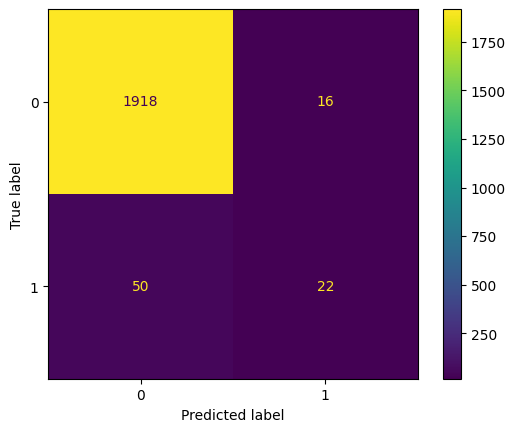

In [21]:
y_prediction = baseline_best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction)

In [22]:
y_test.value_counts()

bad
0    1934
1      72
Name: count, dtype: int64

### IV.E.2. Export Baseline Best Model

In [23]:
# with open("../../models/baseline_best_model.pkl", "wb") as file:
#     pickle.dump(baseline_best_model, file)

## IV.F. Hyperparameter Tuning

### IV.F.1. Hyperparameters List

In [24]:
xgb_hyperparams = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 200, 500],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.5, 0.7, 1],
}

In [25]:
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_hyperparams, n_jobs = -1, verbose = 420)

models_list["vanilla"].append({
    "model_name": xgb_grid_search.__class__.__name__ + "-" + xgb_grid_search.estimator.__class__.__name__,
    "model_object": xgb_grid_search,
    "model_uid": ""
})

C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### IV.F.2. Best Model Hyperparameter Retraining

In [26]:
training_log, models_list_vanilla_tuned = model_training_and_evaluation(
    [models_list["vanilla"][-1]],
    "tuned_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '../../models/logs/training_log.json'
)

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:05<00:00, 305.69s/it]


In [27]:
models_list["vanilla"][-1]

{'model_name': 'GridSearchCV-XGBClassifier',
 'model_object': GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None,...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                    

In [28]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 149.82it/s]


,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,baseline_model-XGBClassifier,f4842d6e5be806acadfca055acd2ea4c,1.388799,2023-06-26 01:08:56.931391,0.691543,vanilla,0.967099,0.974593,0.991727,0.983086,1934,0.578947,0.305556,0.400000,72,0.776770,0.648641,0.691543,2006,0.960393,0.967099,0.962157,2006
1,baseline_model-DecisionTreeClassifier,5c2af905fe1ffb74f12325cb25575d19,0.010611,2023-06-26 01:08:56.595181,0.687711,vanilla,0.966102,0.974568,0.990693,0.982564,1934,0.550000,0.305556,0.392857,72,0.762284,0.648124,0.687711,2006,0.959329,0.966102,0.961398,2006
2,tuned_model-GridSearchCV-XGBClassifier,b33d19fc502c4c782ede0eac5214e134,305.653149,2023-06-26 01:08:59.028941,0.681942,vanilla,0.970588,0.972769,0.997415,0.984937,1934,0.782609,0.250000,0.378947,72,0.877689,0.623707,0.681942,2006,0.965943,0.970588,0.963187,2006
3,baseline_model-RandomForestClassifier,d5ed6d99e3fa1339543d091755714256,0.285403,2023-06-26 01:08:56.616823,0.678526,vanilla,0.965105,0.974059,0.990176,0.982051,1934,0.525000,0.291667,0.375000,72,0.749530,0.640921,0.678526,2006,0.957941,0.965105,0.960263,2006
4,baseline_model-XGBClassifier,454e019bb3710bf2287b3d9e904509b4,1.290744,2023-06-25 22:26:56.772099,0.633410,vanilla,0.969591,0.969895,0.999483,0.984467,1934,0.923077,0.166667,0.282353,72,0.946486,0.583075,0.633410,2006,0.968214,0.969591,0.959266,2006
5,baseline_model-LogisticRegression,28edfb5c7350dd75a060fc7c1d597d44,0.032118,2023-06-26 01:08:56.553534,0.626479,vanilla,0.965105,0.970232,0.994312,0.982125,1934,0.541667,0.180556,0.270833,72,0.755949,0.587434,0.626479,2006,0.954850,0.965105,0.956595,2006
6,baseline_model-DecisionTreeClassifier,482d2b2f238d229ea466266342f2a838,0.007509,2023-06-25 22:26:56.536662,0.623060,vanilla,0.969093,0.969408,0.999483,0.984216,1934,0.916667,0.152778,0.261905,72,0.943037,0.576130,0.623060,2006,0.967515,0.969093,0.958290,2006
7,baseline_model-RandomForestClassifier,6fa2bdc0bb0be2b27131f8798bee2e76,0.194415,2023-06-25 22:26:56.550481,0.623060,vanilla,0.969093,0.969408,0.999483,0.984216,1934,0.916667,0.152778,0.261905,72,0.943037,0.576130,0.623060,2006,0.967515,0.969093,0.958290,2006
8,tuned_model-GridSearchCV-XGBClassifier,dccaf2a39f6d4c9243ed6445cffa83ab,141.853944,2023-06-25 22:26:58.723040,0.601614,vanilla,0.968096,0.968437,0.999483,0.983715,1934,0.900000,0.125000,0.219512,72,0.934218,0.562241,0.601614,2006,0.965981,0.968096,0.956286,2006
9,baseline_model-LogisticRegression,1281fd8e242cc09bc13c922890f4d7a4,0.026823,2023-06-25 22:26:56.499794,0.579107,vanilla,0.967099,0.967467,0.999483,0.983215,1934,0.875000,0.097222,0.175000,72,0.921234,0.548353,0.579107,2006,0.964149,0.967099,0.954206,2006


In [29]:
tuned_best_model = best_model_finder(all_training_logs_df_tuned, models_list)
tuned_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

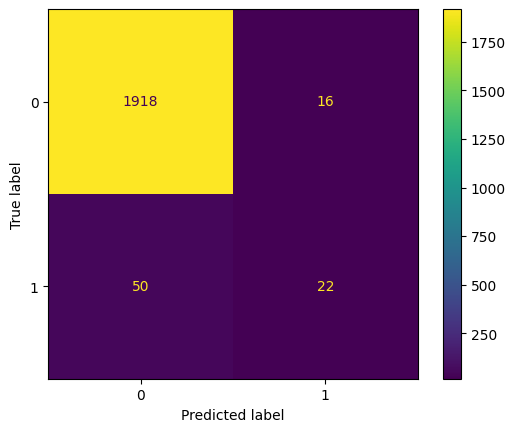

In [30]:
y_prediction = tuned_best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction)

In [ ]:
confusion_matrix

### IV.F.3. Export Hyperparameter-tuned Best Model

In [31]:
# with open("../../models/tuned_best_model.pkl", "wb") as file:
#     pickle.dump(tuned_best_model, file)